# Modeling Short Time Series with Prior Knowledge in PyMC

**Source:** [Modeling Short Time Series with Prior Knowledge](https://minimizeregret.com/short-time-series-prior-knowledge)

## Prepare Notebook

In [64]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from pymc.distributions.continuous import Exponential
from sklearn.preprocessing import StandardScaler
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [69]:
raw_df = pd.read_csv("../data/sales.csv", parse_dates=["date"])

raw_df.head()

,date,sales,temp
0,2013-07-01,57.0,303.0
1,2013-07-02,58.0,298.0
2,2013-07-03,53.0,301.0
3,2013-07-04,36.0,302.0
4,2013-07-05,29.0,305.0


## EDA

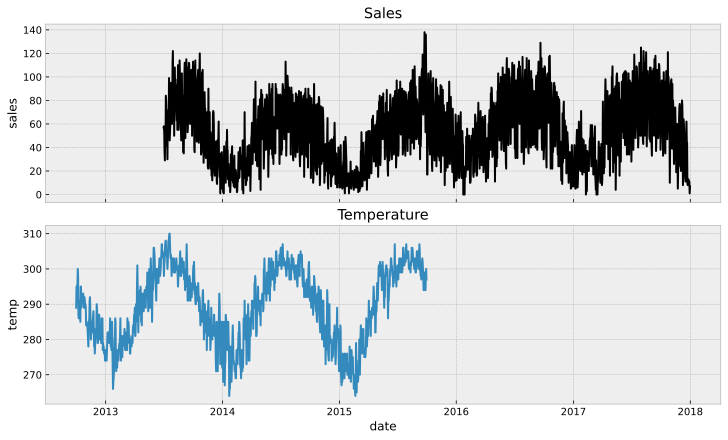

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df, color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df, color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

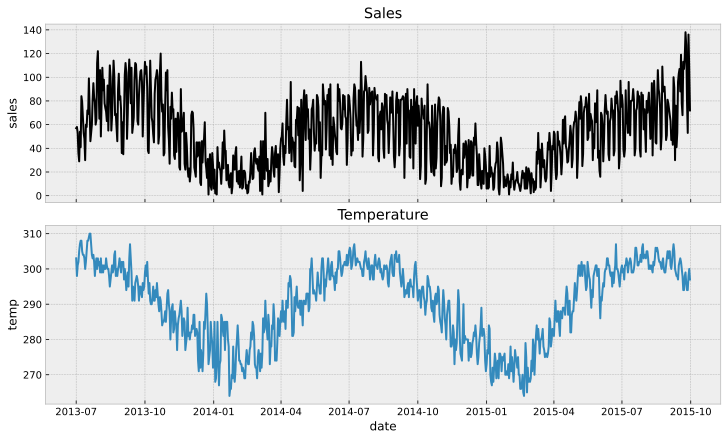

In [67]:
mask = "sales.notnull() and temp.notnull()"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="sales", data=raw_df.query(mask), color="black", ax=ax[0])
sns.lineplot(x="date", y="temp", data=raw_df.query(mask), color="C0", ax=ax[1])
ax[0].set(title="Sales")
ax[1].set(title="Temperature");

In [78]:
df = raw_df.query("temp.notnull()").sort_values("date").reset_index(drop=True).copy()

train_test_date = pd.to_datetime("'2013-10-15'")

df_train = df.query("date < @train_test_date")
df_test = df.query("date >= @train_test_date")

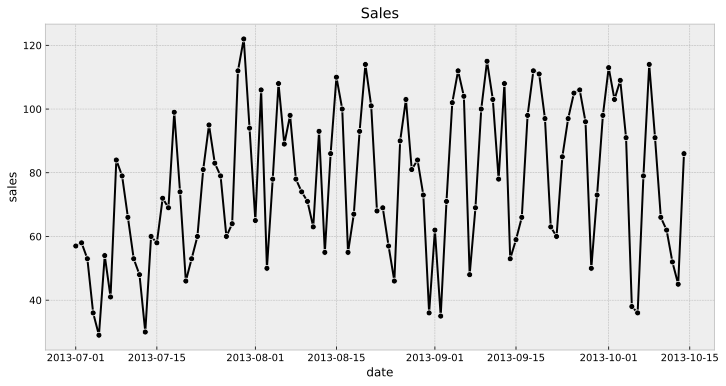

In [79]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="sales", data=df_train, color="black", marker="o", ax=ax)
ax.set(title="Sales");

## Temperature Model

In [90]:
date = df["date"]
temp_scaled = df.eval("temp_scaled = temp - temp.min()")["temp_scaled"]

In [91]:
periods = df["date"].dt.dayofyear / 365.25
n_order = 6

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

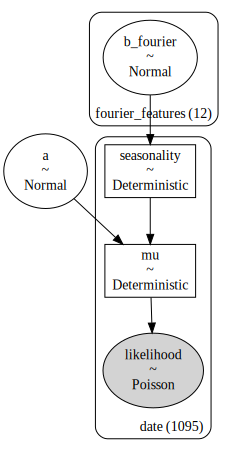

In [102]:
coords = {
    "date": date,
    "fourier_features": np.arange(2 * n_order),
}

with pm.Model(coords=coords) as temp_model:
    # --- priors ---
    ## intercept
    a = pm.Normal(name="a", mu=0, sigma=0.5)
    ## seasonality
    b_fourier = pm.Normal(name="b_fourier", mu=0, sigma=0.5, dims="fourier_features")
    # --- model parametrization ---
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(b_fourier, fourier_features.to_numpy().T), dims="date"
    )
    mu = pm.Deterministic(name="mu", var= a + seasonality, dims="date")

    # --- likelihood ---
    pm.Poisson("likelihood", mu=pm.math.exp(mu), observed=temp_scaled, dims="date")

pm.model_to_graphviz(temp_model)

In [103]:
with temp_model:
    temp_prior_predictive = pm.sample_prior_predictive(samples=1000)

In [104]:
with temp_model:
    temp_idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.9, draws=4000, chains=4
    )
    temp_posterior_predictive = pm.sample_posterior_predictive(trace=temp_idata)

Compiling...
Compilation time =  0:00:03.385060
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:03.866762
Transforming variables...
Transformation time =  0:00:00.109308
Computing Log Likelihood...
Log Likelihood time =  0:00:01.242119


In [106]:
az.summary(data=temp_idata, var_names=["b_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_fourier[0],-0.248,0.009,-0.265,-0.231,0.0,0.0,21294.0,13504.0,1.0
b_fourier[1],-0.547,0.010,-0.565,-0.529,0.0,0.0,18907.0,12646.0,1.0
b_fourier[2],-0.122,0.009,-0.140,-0.105,0.0,0.0,18927.0,12079.0,1.0
b_fourier[3],-0.049,0.009,-0.067,-0.032,0.0,0.0,20330.0,12993.0,1.0
b_fourier[4],-0.046,0.009,-0.064,-0.029,0.0,0.0,20120.0,13288.0,1.0
b_fourier[5],0.047,0.009,0.030,0.064,0.0,0.0,20357.0,13424.0,1.0
b_fourier[6],-0.005,0.009,-0.022,0.012,0.0,0.0,20005.0,13042.0,1.0
b_fourier[7],0.046,0.009,0.028,0.063,0.0,0.0,22698.0,13747.0,1.0
b_fourier[8],-0.000,0.009,-0.017,0.017,0.0,0.0,21414.0,13394.0,1.0
b_fourier[9],0.016,0.009,-0.001,0.034,0.0,0.0,20585.0,13353.0,1.0


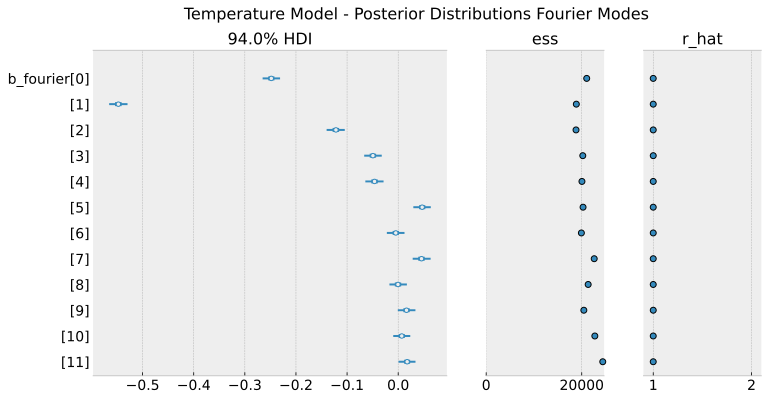

In [112]:
ax = az.plot_forest(
    data=temp_idata,
    var_names=["b_fourier"],
    combined=True,
    r_hat=True,
    ess=True,
    figsize=(12, 6),
)
plt.gcf().suptitle(
    "Temperature Model - Posterior Distributions Fourier Modes", fontsize=16
);